# Assignment 3 - Supervised classification applied on traffic data 
<hr>

Traffic congestion is everywhere. Here, we provide three different perspectives of a congestion - traveler's, traffic at a given moment mapped on a GIS map and in the form of a space-time speed map (space-time map is explained in the video). 
<img src="traffic jam.png">

There are different kinds of traffic congestions, which could be attributed to different causes. For example, if somebody makes a sudden break at a highway, it can create the first pattern given below whereas the second pattern is the congestion caused because of a huge fire near the Schipol tunnel in 2017.
<img src="examples.png">

Thus, if we can group these different types of congestion and add context to these groups, we can use it for diagnostic and prediction purposes. For eg. if all the patterns in a group are caused by heavy rainfall, we can classify them. Thus, given the current traffic state and the weather, we can predict how the congestion will evolve and hence mitigate them. But for this, we first need to classify. In literature, the congestion are mainly categorised into 6 groups and hence the data is also manually classified into these 6 classes. And you are going to build a classifier for these congestion types in this assignment.

## Data


The speed and flow data is collected from the A13 highway corridor in the Netherlands using loop detectors for the months of October from 2012 to 2020. We estimate the travel time for the corridor from speed and flow. The speed and flow data has been used during the course and for the assignment, you will be working with the travel time. The structure of the pandas dataframe is as follows:

- **id**: pattern id
- **date**: measurement date
- **speed**: speed matrix of size space X time, speed is measured every 30 seconds
- **flow**: flow matrix of size space X time, flow is measured every 30 seconds
- **space**: relative distance of the highway corridor sampled every 200 meters
- **time**: measurement time resolution of speed and flow
- **travel_time**: estimated travel time of the corridor at specific time
- **travel_time_time**: time resolution of estimated travel time
- **label**: manually classified label of the congestion patterns

The relevant features are date, travel_time, travel_time_time, label

NOTE: The manual classification was done based on the speed matrix. The time aggregation of the travel time data is different from the aggregation of the speed and flow data. Account for this if you use speed and flow for your analysis.

<img src="input.png">

## Instruction

The tasks are defined in each section. 
- Implement the solutions using code cells and write your analysis using markdown cells. 
- Once you have completed everything, remember to restart the kernel and run all cells again. Make sure there are no errors. 
- Save the notebook (replace XX in the filename with your group number). 
- Export a HTML version of the notebook. Hint: Menu -> File -> Download as -> HTML. 
- Submit both the notebook (.ipynb) and the export (.html)

## Justify all you answers with code or visualisations or numbers! Max 200 words per answer!

<hr>

In [1]:
#all library imports
%matplotlib inline
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 0

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

FileNotFoundError: [Errno 2] No such file or directory: 'Assignment3_dataset_october'

## Task 1 - Data Preprocessing

QUESTION 1: Is the raw travel time sufficient to distinguish between the six classes?
Hint: Use TSNE or LDA

In [3]:
# check for imballance in the number of measurements each day
# and get the smallest number of measurments
len_lst = []
for data_per_day in dataset['travel_time']:
    len_lst.append(len(data_per_day))
num_resize = min(len_lst)

# the size of matrix are different size for the samples, so resize raw data 
def raw_features_resized(speed):
  return speed[:num_resize]
dataset['travel_time_resized'] = dataset['travel_time'].apply(raw_features_resized)

NameError: name 'dataset' is not defined

[Text(0.5, 1.0, 'LDA')]

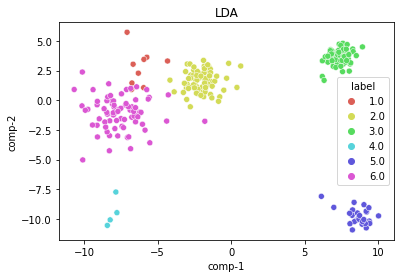

In [5]:
# Perform feature detection on the raw (resized) traveltime data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = np.stack(dataset['travel_time_resized'])
y = dataset['label'].to_numpy()

lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, y).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA")

#Answer

QUESTION 2: The travel time of a day have an aggregation of one minute. Is this time aggregation of the dataset necessary? Or can you aggregate the data further in time for the classification? 

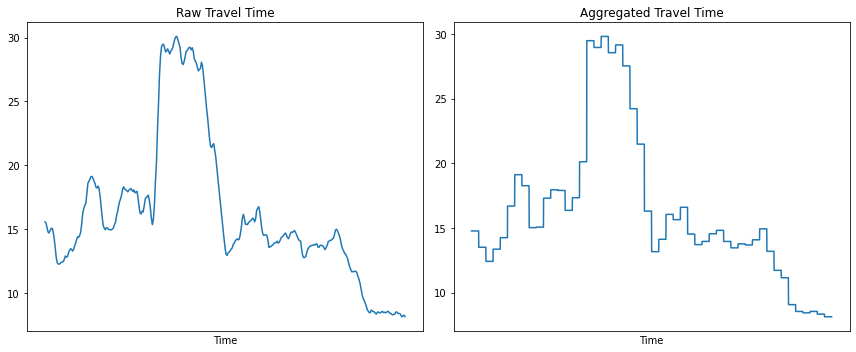

In [6]:
# aggregate the traveltime data
import cv2

day = 0
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(dataset.iloc[day].travel_time_time, dataset.iloc[day].travel_time)
axes[0].set_xticks([])
axes[0].set_xlabel('Time')
axes[0].set_title('Raw Travel Time')

img_aggr = cv2.resize(np.array(dataset.iloc[day].travel_time), (50, 50))
time_trace = img_aggr.flatten()
axes[1].plot(time_trace)
axes[1].set_xticks([])
axes[1].set_xlabel('Time')
axes[1].set_title('Aggregated Travel Time')

plt.tight_layout()
plt.show()

#Answer

QUESTION 3: Does the aggregated travel time data sufficient to distinguish between the six classes. 

In [7]:
# aggregate data
def aggregate(item):
  return cv2.resize(np.array(item), (250, 250)).flatten()
dataset["travel_time_resized_agg"] = dataset['travel_time_resized'].apply(aggregate)

X_agg = np.stack(dataset["travel_time_resized_agg"])

lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X_agg, y).transform(X_agg)
dataset["comp-1_agg"] = X_r[:,0]
dataset["comp-2_agg"] = X_r[:,1]

Text(0.5, 1.0, 'Aggregated travel time feature detection')

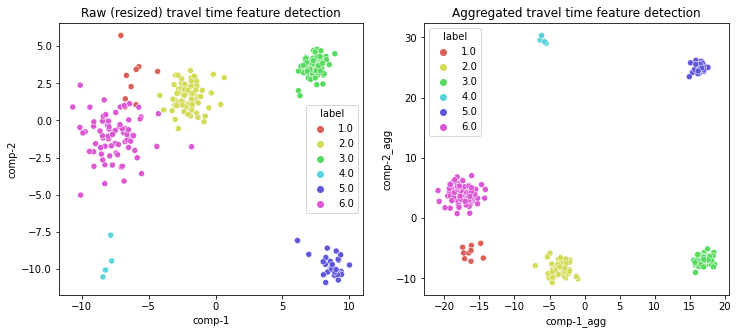

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset, ax=axes[0]).set(title="LDA")
axes[0].set_title('Raw (resized) travel time feature detection')

sns.scatterplot(x="comp-1_agg", y="comp-2_agg", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset, ax=axes[1]).set(title="LDA")
axes[1].set_title('Aggregated travel time feature detection')

#Answer

## Bonus Question - High level features

QUESTION 4: Extract high-level features from the travel time dataset using any method or detector. Visualise the output of the detector with an example travel time vector.

In [8]:
#Code

#Answer

QUESTION 5: Is the high-level features sufficient to distinguish between the six classes. 

In [9]:
#Code

#Answer

## Task 2 - Probablistic Classifier

QUESTION 6: Divide the dataset into test, train and validation dataset. Build a logistic classifier for the dataset. Use leave-one-out validation strategy for the classifier. Justify the parameter selection

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = np.stack(dataset['travel_time_resized'])
Y = dataset['label']
rand_seed = 1
X_train, _X, Y_train, _Y = train_test_split(X, Y, train_size=0.5, stratify=Y, random_state=rand_seed)
X_validate, X_test, Y_validate, Y_test = train_test_split(_X, _Y, train_size=0.5, stratify=_Y, random_state=rand_seed)

In [35]:
def show_conf_matrix(y_true, y_pred):
    logreg_conf = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 3))
    sns.heatmap(logreg_conf, annot=True, fmt='.0%', cmap='Blues')
    plt.show()

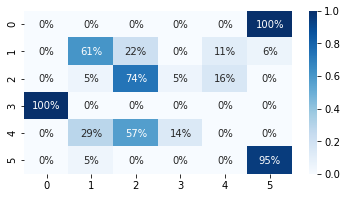

In [36]:
logreg = LogisticRegression(C=1e5, max_iter=1000)
# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, Y_train)
Ypred_test = logreg.predict(X_test)
show_conf_matrix(Y_test, Ypred_test)

#Answer

QUESTION 7: Evaluate the classification results with atleast 2 metrics. Justify your choice of metric.  

In [11]:
#Code

#Answer

QUESTION 8: Comment on the statistics of the probabilities in majority and minority classes

In [12]:
#Code

#Answer

## Task 3 - Random Forest Classifier

QUESTION 9: Build a random forest classifier for the dataset. Use k-fold validation strategy for the classifier

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

def k_fold_training(X_train, model, verbal=False):
    # Setup the k-fold cross-validation
    CV = KFold()
    CV.n_splits     = 5     # k
    CV.shuffle      = True
    CV.random_state = 1

    # Train clf k times on k different data splits (k-fold cross validation)
    for train_index, test_index in CV.split(X_train):
        X_train_cv, X_test_cv = X[train_index, :], X[test_index, :]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_values_cv = model.predict(X_test_cv)

        acc = accuracy_score(y_test_cv, y_pred_values_cv)
        print(f'Accuracy score: {acc.round(3)}') if verbal else None

    return model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Get input and output data; X and y
X = np.stack(dataset['travel_time_resized_agg'])
y = dataset['label']

# Split data into a train, test, and validation set
X_train, _X, y_train, _y = train_test_split(X, y, train_size=0.5, random_state=1)
X_validate, X_test, y_validate, y_test = train_test_split(_X, _y, train_size=0.5, random_state=1)

# Define the random forest classifier as clf
clf = RandomForestClassifier()
clf.n_estimators = 100
clf.max_depth    = 100
clf.random_state = 1

# Perform the k-fold cross-validation training
clf = k_fold_training(X_train, clf, verbal=True)


Accuracy score: 0.852
Accuracy score: 0.593
Accuracy score: 0.741
Accuracy score: 0.692
Accuracy score: 0.731


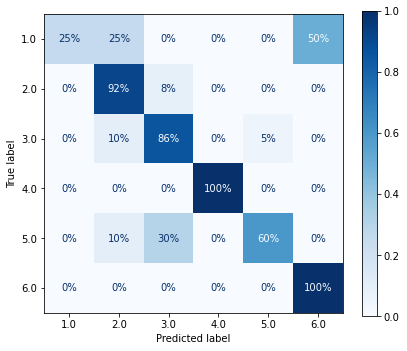

              precision    recall  f1-score   support

         1.0       1.00      0.25      0.40         4
         2.0       0.73      0.92      0.81        12
         3.0       0.82      0.86      0.84        21
         4.0       1.00      1.00      1.00         2
         5.0       0.86      0.60      0.71        10
         6.0       0.90      1.00      0.95        18

    accuracy                           0.84        67
   macro avg       0.88      0.77      0.78        67
weighted avg       0.85      0.84      0.82        67



In [13]:
from sklearn.metrics import plot_confusion_matrix, classification_report

fig, ax = plt.subplots(1, figsize=(6, 5))
plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap='Blues', ax=ax, values_format='.0%') 
plt.tight_layout()
plt.show()

print(classification_report(y_test, clf.predict(X_test)))

#Answer

QUESTION 10: Conduct a sensitivity analysis of atleast two parameters of the random forest decision trees. Note: You dont need to find the optimal parameters but should conduct a sensitivity analysis.

In [14]:
from sklearn.metrics import accuracy_score

sensitivity = {'n_estimators':  np.arange(10, 150 +5, 5),
               'max_depth':     np.arange( 1,  15 +1, 1)}

accuracy_dict = {}
for item in sensitivity.keys():
    accuracy_dict[item] = []
    for value in sensitivity[item]:
        clf_val = RandomForestClassifier()
        clf_val.n_estimators = value if item == 'n_estimators' else 100
        clf_val.max_depth    = value if item == 'max_depth' else 100
        clf_val.random_state = 1

        clf_val.fit(X_train, y_train)   # train the validation model

        acc = accuracy_score(y_validate, clf_val.predict(X_validate))   # test the validation model
        accuracy_dict[item].append(acc)

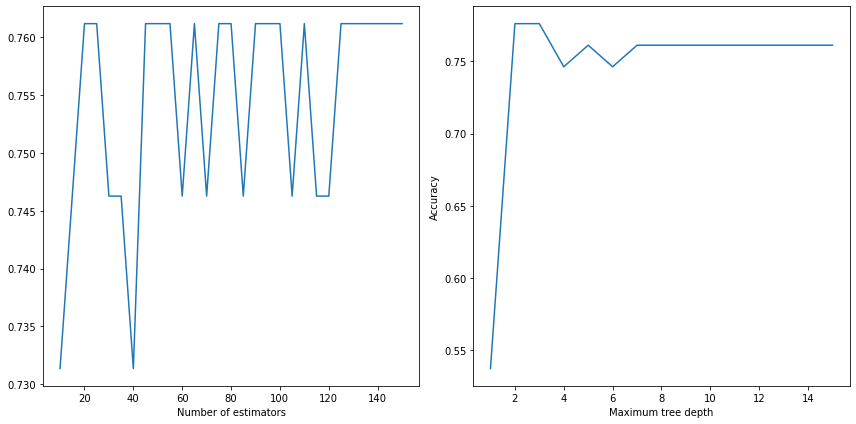

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(sensitivity['n_estimators'], accuracy_dict['n_estimators'])
axes[0].set_xlabel('Number of estimators')
axes[1].set_ylabel('Accuracy')

axes[1].plot(sensitivity['max_depth'], accuracy_dict['max_depth'])
axes[1].set_xlabel('Maximum tree depth')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

#Answer

QUESTION 11: Analyse one of the pattern that is wrongly classified and explain why you think it is wrongly classified?

#Answer

## Task 4 - Feature Importance

QUESTION 12: Visualise one of the random tree. Comment on the tree structure

In [16]:
#Visualise one of the tree
plt.figure(figsize=(12,12))
tree.plot_tree(clf.estimators_[10], fontsize=8) 
plt.show()

#Answer

QUESTION 13: Analyse the random forest feature importance and comment on the findings.

In [17]:
# get importance
Ypred_test = clf.predict(X_test)
importance = clf.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Resized Feature Dimensions')
plt.ylabel('Score')
plt.show()

#Answer

## Task 5 - Reflection

QUESTION 14: Given your analysis of the data, do you consider this a supervised classification problem or do you think it can also be solved as a unsupervised learning problem. (No need of coding. Just reflect!)

#Answer